## Exploring the Global Streetscapes dataset

Here we familiarize ourselves with the data contained within the [Global Streetscapes](https://ual.sg/project/global-streetscapes/) dataset and introduce some tools and utilities to easily explore it. 

The Global Streetscapes dataset provides context and metadata to millions of crowdsourced images from [Mapillary](https://www.mapillary.com/) and [Kartaview](https://kartaview.org/), covering 688 cities around the world.  The dataset contains more than 300 attributes and has wide geographical, environmental and temporal diversity. 

This rich metadata set could be a great starting point for street view imagery analysis. In this notebook, rather than fetching images directly from source, we start from this dataset to both do some analysis based on the existing metadata and using this information to narrow down the images we would like to download.

In [21]:
import geopandas as gpd
import contextily
from PIL import Image

import ibis
ibis.options.interactive = True

from streetscapes.sources import GlobalStreetscapesSource, Mapillary, KartaView
from streetscapes.streetview import SVWorkspace

First, we can create a workspace and add Global Streetscapes as a data source. 

In [22]:
ws = SVWorkspace("../Amsterdam", create=True)

Let's load the `info.csv`, which contains the information on all of the different files and their corresponding metadata and attributes of the Global Streetscapes dataset. 

In [23]:
gss = GlobalStreetscapesSource(ws.env)
info = gss.load_csv("info", root=gss.root_dir)
info

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ column0 ┃ Filename       ┃ Overview                                                                ┃ Notes                                                                            ┃ Field              ┃ Format ┃ Explanation                                                                      ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64   │ string         │ string                                                                  │ string                                                                           │ string             │ string │ string                                                                           │
├─────────┼────────────────┼─────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼────────────────────┼────────┼──────────────────────────────────────────────────────────────────────────────────┤
│       1 │ climate.csv    │ Contains the Koppen climate zone associated with each image's location. │ The calculation is as accurate as the location of the image given by the source… │ uuid               │ string │ Universally Unique IDentifier, unique for every image                            │
│    NULL │ NULL           │ NULL                                                                    │ NULL                                                                             │ source             │ string │ Source of the image, either Mapillary or KartaView                               │
│    NULL │ NULL           │ NULL                                                                    │ NULL                                                                             │ orig_id            │ int    │ Original ID of the image as specified by Mapillary or KartaView                  │
│    NULL │ NULL           │ NULL                                                                    │ NULL                                                                             │ koppen_geiger_zone │ string │ A zone code to identify the Koppen climate zone                                  │
│    NULL │ NULL           │ NULL                                                                    │ NULL                                                                             │ zone_description   │ string │ Short description of the climate zone                                            │
│       2 │ contextual.csv │ Contains the eight contextual attributes inferred for each image.       │ Please refer to Table 3 in the paper for information on accuracy.                │ uuid               │ string │ Universally Unique IDentifier, unique for every image                            │
│    NULL │ NULL           │ NULL                                                                    │ NULL                                                                             │ source             │ string │ Source of the image, either Mapillary or KartaView                               │
│    NULL │ NULL           │ NULL                                                                    │ NULL                                                                             │ orig_id            │ int    │ Original ID of the image as specified by Mapillary or KartaView                  │
│    NULL │ NULL           │ NULL                                                                    │ NULL      

If we want to look at all of the different files available and what they contain, we can do the following:

In [25]:
filenames = info.to_pandas()
filenames = filenames[~filenames["Filename"].isnull()]
filenames.head()

column0        Filename  \
0       1.0     climate.csv   
5       2.0  contextual.csv   
16      3.0       ephem.csv   
24      4.0        gadm.csv   
65      5.0        ghsl.csv   

                                             Overview  \
0   Contains the Koppen climate zone associated wi...   
5   Contains the eight contextual attributes infer...   
16  Contains the temporal information of each imag...   
24  Contains the administrative area associated wi...   
65  Contains the degree of urbanisation associated...   

                                                Notes Field  Format  \
0   The calculation is as accurate as the location...  uuid  string   
5   Please refer to Table 3 in the paper for infor...  uuid  string   
16  The accuracy of the calculation is as accurate...  uuid  string   
24  The calculation is as accurate as the location...  uuid  string   
65  The calculation is as accurate as the location...  uuid  string   

                                          Explanation  
0   Universally Unique IDentifier, unique for ever...  
5   Universally Unique IDentifier, unique for ever...  
16  Universally Unique IDentifier, unique for ever...  
24  Universally Unique IDentifier, unique for ever...  
65  Universally Unique IDentifier, unique for ever...

### Loading the data

We can load the entire `streetscapes.parquet` set from Global Streetscapes with the `load_parquet()` function. This uses [`ibis`](https://ibis-project.org/) in the background, which is able to handle data a lot faster than `pandas` and is therefore useful for handling larger datasets. 

`streetscapes.parquet` combines the following csv files from the original dataset: contextual.csv, metadata_common_attributes.csv, segmentation.csv, simplemaps.csv, ghsl.csv, perception.csv, places365.csv, and osm.csv

In [26]:
# Load streetscapes.parquet dataset
streetscapes = gss.load_parquet("streetscapes")
streetscapes.head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ uuid                                 ┃ source    ┃ orig_id         ┃ glare   ┃ lighting_condition ┃ pano_status ┃ platform        ┃ quality       ┃ reflection ┃ view_direction ┃ weather ┃ lat        ┃ lon        ┃ datetime_local          ┃ year  ┃ month ┃ day   ┃ hour  ┃ width   ┃ height  ┃ heading    ┃ projection_type ┃ hFoV      ┃ vFoV      ┃ sequence_index ┃ sequence_id            ┃ sequence_img_count ┃ Bird    ┃ Ground-Animal ┃ Curb    ┃ Fence    ┃ Guard-Rail ┃ Barrier ┃ Wall    ┃ Bike-Lane ┃ Crosswalk---Plain ┃ Curb-Cut ┃ Parking ┃ Pedestrian-Area ┃ Rail-Track ┃ Road         ┃ Service-Lane ┃ Sidewalk ┃ Bridge   ┃ Building ┃ Tunnel  ┃ Person  ┃ Bicyclist ┃ Motorcyclist ┃ Other-Rider ┃ Lane-Marking---Crosswalk ┃ Lane-Marking---General ┃ Mountain ┃ Sand    ┃ Sky          ┃ Snow    ┃ Terrain  ┃ Vegetation   ┃ Water   ┃ Banner  ┃ Bench   ┃ Bike-Rack ┃ Billboard ┃ Catch-Basin ┃ CCTV-Camera ┃ Fire-Hydrant ┃ Junction-Box ┃ Mailbox ┃ Manhole ┃ Phone-Booth ┃ Pothole ┃ Street-Light ┃ Pole    ┃ Traffic-Sign-Frame ┃ Utility-Pole ┃ Traffic-Light ┃ Traffic-Sign-(Back) ┃ Traffic-Sign-(Front) ┃ Trash-Can ┃ Bicycle ┃ Boat    ┃ Bus     ┃ Car     ┃ Caravan ┃ Motorcycle ┃ On-Rails ┃ Other-Vehicle ┃ Trailer ┃ Truck   ┃ Wheeled-Slow ┃ Car-Mount ┃ Ego-Vehicle ┃ Total        ┃ green_view_index ┃ sky_view_index ┃ city          ┃ city_ascii    ┃ city_id    ┃ city_lat ┃ city_lon ┃ country        ┃ iso2   ┃ iso3   ┃ admin_name             ┃ capital ┃ population   ┃ continent     ┃ urban_code ┃ urban_term             ┃ Beautiful ┃ Boring  ┃ Depressing ┃ Lively  ┃ Safe    ┃ Wealthy ┃ place                    ┃ snap_dist ┃ u            ┃ v            ┃ key     ┃ osmid                          ┃ oneway  ┃ lanes  ┃ name                      ┃ highway   ┃ type_highway ┃ maxspeed ┃ junction ┃ length   ┃ from         ┃ to           ┃ ref         ┃ tunnel_1 ┃ bridge_1 ┃ service ┃ access ┃ road_width ┃ area    ┃ est_width ┃ reversed ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━

If you need data from other files, or only data from one file, then individual parquet files are also available.

Let's load `perception.parquet`, which is included in streetscapes.parquet, as an example:

In [27]:
perception = gss.load_parquet("perception")
perception

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ uuid                                 ┃ source    ┃ orig_id      ┃ Beautiful ┃ Boring  ┃ Depressing ┃ Lively  ┃ Safe    ┃ Wealthy ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ string                               │ string    │ float64      │ float64   │ float64 │ float64    │ float64 │ float64 │ float64 │
├──────────────────────────────────────┼───────────┼──────────────┼───────────┼─────────┼────────────┼─────────┼─────────┼─────────┤
│ 12039441-fd9e-4ca9-bc0f-957b713e12f1 │ KartaView │ 5.658903e+08 │      1.32 │    2.03 │       2.21 │    5.87 │    0.38 │    5.29 │
│ 05a2f4e8-4a15-4c69-afcc-b411c4b995e5 │ KartaView │ 5.658903e+08 │      4.23 │    1.82 │       1.38 │    2.70 │    0.76 │    4.52 │
│ 5292f74f-a519-4536-828b-f19de21f0df3 │ KartaView │ 5.658903e+08 │      1.67 │    3.52 │       0.84 │    3.39 │    1.00 │    2.57 │
│ 1593f561-d6cd-4936-88d7-3675efc9421e │ KartaView │ 5.658903e+08 │      1.97 │    2.71 │       3.42 │    4.61 │    1.67 │    3.95 │
│ 4a05386c-cd98-42fc-9e3c-f361f32a8ed7 │ KartaView │ 5.658903e+08 │      6.43 │    1.14 │       1.72 │    4.48 │    0.55 │    2.29 │
│ 57294d2f-13a9-40e1-b13e-0a809d131e6d │ KartaView │ 5.658906e+08 │      2.44 │    0.83 │       4.45 │    6.64 │    1.07 │    4.88 │
│ 2010ce23-3254-4b19-8b81-b9f614ec7932 │ KartaView │ 5.658904e+08 │      2.85 │    0.93 │       1.82 │    6.51 │    0.54 │    3.92 │
│ 5c00ea5b-1487-4499-b1a7-da1a348c550c │ KartaView │ 5.658903e+08 │      1.62 │    0.92 │       1.68 │    2.98 │    0.82 │    2.60 │
│ fca19492-6132-4790-8d57-0a3f0f42cc98 │ KartaView │ 5.696926e+08 │      2.42 │    2.47 │       4.22 │    5.00 │    2.33 │    0.37 │
│ 6c51acf6-5681-40c4-b00b-781bcf6be54d │ KartaView │ 5.658905e+08 │      1.60 │    3.77 │       1.94 │    4.71 │    0.66 │    2.10 │
│ …                                    │ …         │            … │         … │       … │          … │       … │       … │       … │
└──────────────────────────────────────┴───────────┴──────────────┴───────────┴─────────┴────────────┴─────────┴─────────┴─────────┘

In [28]:
perception.columns

('uuid',
 'source',
 'orig_id',
 'Beautiful',
 'Boring',
 'Depressing',
 'Lively',
 'Safe',
 'Wealthy')

### Explore the data

Now, prepare a subset of Global Streetscapes by selecting entries for the city of Amsterdam. The subset name is composed of a path relative to the root directory of the workspace (`subsets`) and the file name (`amsterdam`). By default, subsets are saved as `parquet` files, so we don't have to specify the extension.

In [29]:
# Subset name (path relative to the root directory of the workspace + file name without the .parquet extension)
subset = "subsets/amsterdam"

# Criteria used to filter the large Global Streetscapes dataset.
criteria = {"city": "Amsterdam"}

# Create the subset and assign it to a variable that we can use below.
# The method also returns the path to the saved subset if the dataset was saved to disk (triggered by save=True).
ams = gss.load_dataset(criteria=criteria)

Check the path to the saved subset file. It should be a path relative to the root directory of the workspace and the first few lines of the subset:

In [30]:
print(ams.head())

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━
┃ uuid                                 ┃ source    ┃ orig_id          ┃ glare   ┃ lighting_condition ┃ pano_status 
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━
│ string                               │ string    │ int64            │ boolean │ string             │ boolean     
├──────────────────────────────────────┼───────────┼──────────────────┼─────────┼────────────────────┼─────────────
│ 840d52d5-1bbe-4f77-ac5a-5d8905dca06e │ Mapillary │ 2585835221712723 │ False   │ day                │ True        
│ 6a81f09d-24b9-4179-8eb5-9cd2e91c13d9 │ Mapillary │ 4130433687048823 │ False   │ day                │ False       
│ 26c37fae-3485-4ca1-8b97-9f449a8da680 │ Mapillary │  219442182852752 │ False   │ day                │ False       
│ b8ae9b6a-deb3-4e85-a6e9-75c03f77573e │ Mapillary │ 4077211285668521 │ 

...and the total number of rows.

In [31]:
ams.count()

┌───────┐
│ 25950 │
└───────┘

#### Perception Example

We can subset the dataset further by selecting columns we want to keep and specifying criteria, such as time of day the image was taken or the viewing angle. Here we take images taken during the day on a walking surface and keep columns related to perception.

In [32]:
columns = {'uuid', 'source', 'lat', 'lon', "orig_id", "Beautiful", "Depressing", "Safe"}

criteria = {"city": "Amsterdam", "lighting_condition": "day", "platform": "walking surface"}
ams_walk = gss.load_dataset(criteria=criteria, columns=columns)

criteria = {"city": "Amsterdam", "lighting_condition": "day", "platform": "driving surface"}
ams_drive = gss.load_dataset(criteria=criteria, columns=columns)

We can now plot the data by convert the data to a GeoDataFrame with GeoPandas. As an example we are plotting the perception of 'safety' for images of walking surfaces vs driving surfaces. We can see that generally driving surfaces are seen as less 'safe'. 

In [33]:
import matplotlib.pyplot as plt

def convert_to_gdf(table):
    """Convert dataset to GeoDataFrame"""
    df = table.to_pandas()
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat),  crs="EPSG:4326")
    return gdf

def plot_gdf(gdf, column, ax):
    """Plot GeoDataFrame with basemap"""
    legend_kwds = {'label': column, 'shrink': 0.6}
    ax = gdf.plot(column=column, ax=ax, cmap='RdYlGn', markersize=3, alpha=0.5, legend=True, legend_kwds=legend_kwds)
    contextily.add_basemap(ax, crs=gdf.crs, source=contextily.providers.nlmaps.pastel)
    return ax

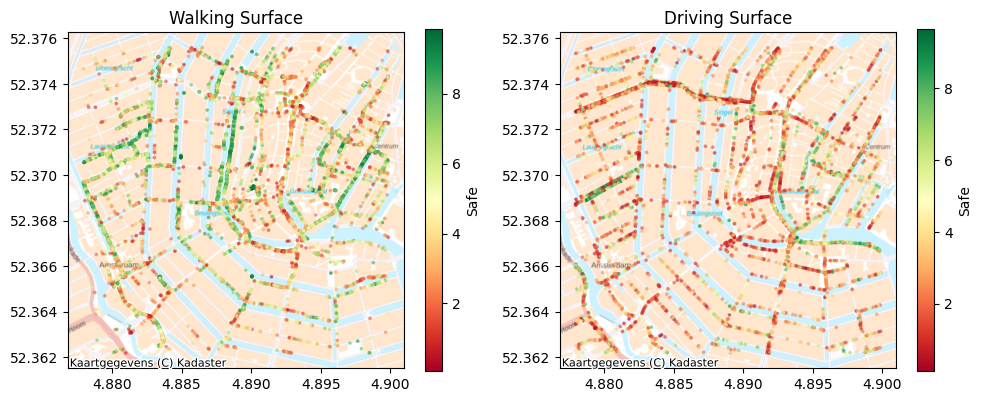

In [34]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot the GeoDataFrame on the first subplot
gdf_walk = convert_to_gdf(ams_walk)
ax = plot_gdf(gdf_walk, "Safe", ax1)
ax1.set_title('Walking Surface')

# Plot the raster on the second subplot
gdf_drive = convert_to_gdf(ams_drive)
ax = plot_gdf(gdf_drive, "Safe", ax2)
ax2.set_title('Driving Surface')

# Show the plot
plt.tight_layout()
plt.show()

#### Building Fraction Example

We can take this idea further and create new columns for aspects we are interested in and filter the data. For example, we can calculate the building fraction of each image and filter for images where more than 15% of the pixels are buildings. 

In [35]:
# Calculate building fraction and create new column
building_fraction = ams["Building"] / ams["Total"]
ams = ams.mutate(building_fraction=building_fraction)

# Filter for buildings
ams_buildings = ams.filter(ams["building_fraction"] > 0.3)
ams_buildings.head(5)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ uuid                                 ┃ source    ┃ orig_id          ┃ glare   ┃ lighting_condition ┃ pano_status ┃ platform        ┃ quality       ┃ reflection ┃ view_direction ┃ weather ┃ lat       ┃ lon      ┃ datetime_local          ┃ year  ┃ month ┃ day   ┃ hour  ┃ width   ┃ height  ┃ heading    ┃ projection_type ┃ hFoV      ┃ vFoV      ┃ sequence_index ┃ sequence_id            ┃ sequence_img_count ┃ Bird    ┃ Ground-Animal ┃ Curb    ┃ Fence   ┃ Guard-Rail ┃ Barrier ┃ Wall    ┃ Bike-Lane ┃ Crosswalk---Plain ┃ Curb-Cut ┃ Parking ┃ Pedestrian-Area ┃ Rail-Track ┃ Road     ┃ Service-Lane ┃ Sidewalk ┃ Bridge  ┃ Building     ┃ Tunnel  ┃ Person   ┃ Bicyclist ┃ Motorcyclist ┃ Other-Rider ┃ Lane-Marking---Crosswalk ┃ Lane-Marking---General ┃ Mountain ┃ Sand    ┃ Sky      ┃ Snow    ┃ Terrain ┃ Vegetation ┃ Water   ┃ Banner  ┃ Bench   ┃ Bike-Rack ┃ Billboard ┃ Catch-Basin ┃ CCTV-Camera ┃ Fire-Hydrant ┃ Junction-Box ┃ Mailbox ┃ Manhole ┃ Phone-Booth ┃ Pothole ┃ Street-Light ┃ Pole    ┃ Traffic-Sign-Frame ┃ Utility-Pole ┃ Traffic-Light ┃ Traffic-Sign-(Back) ┃ Traffic-Sign-(Front) ┃ Trash-Can ┃ Bicycle ┃ Boat    ┃ Bus     ┃ Car      ┃ Caravan ┃ Motorcycle ┃ On-Rails ┃ Other-Vehicle ┃ Trailer ┃ Truck   ┃ Wheeled-Slow ┃ Car-Mount ┃ Ego-Vehicle ┃ Total        ┃ green_view_index ┃ sky_view_index ┃ city      ┃ city_ascii ┃ city_id    ┃ city_lat ┃ city_lon ┃ country     ┃ iso2   ┃ iso3   ┃ admin_name    ┃ capital ┃ population ┃ continent ┃ urban_code ┃ urban_term   ┃ Beautiful ┃ Boring  ┃ Depressing ┃ Lively  ┃ Safe    ┃ Wealthy ┃ place        ┃ snap_dist ┃ u            ┃ v            ┃ key     ┃ osmid     ┃ oneway  ┃ lanes  ┃ name                    ┃ highway      ┃ type_highway ┃ maxspeed ┃ junction ┃ length  ┃ from         ┃ to           ┃ ref    ┃ tunnel_1         ┃ bridge_1 ┃ service ┃ access ┃ road_width ┃ area    ┃ est_width ┃ reversed ┃ building_fraction ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━

Again, we can plot this data to see if we have a good spatial coverage. 

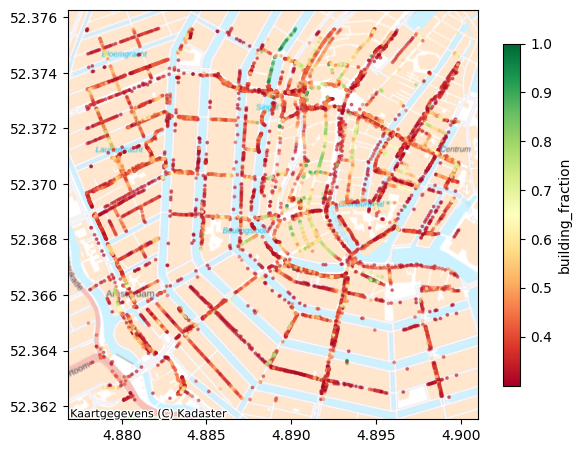

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
gdf = convert_to_gdf(ams_buildings)
ax = plot_gdf(gdf, "building_fraction", ax)
plt.tight_layout()
plt.show()

### Download Images

Next, we will download images for the Amsterdam subset that we created above by using the images sources that we loaded into our workspace. We can download all the images corresponding to a data source in one go. However, the unified API of all image sources requires that the dataset contain two hardwired columns: `source` and `image_id`. This is a design choice to avoid having to handle potentially very different sources. Ibis makes it trivial to remap column names with the `select` method by providing a dictionary with the desired column names as keys and the existing columns that they map to as values.

In [37]:
src_table = ams.select({"source": "source", "image_id": "orig_id"})
ams

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ uuid                                 ┃ source    ┃ orig_id          ┃ glare   ┃ lighting_condition ┃ pano_status ┃ platform        ┃ quality       ┃ reflection ┃ view_direction ┃ weather ┃ lat       ┃ lon      ┃ datetime_local          ┃ year  ┃ month ┃ day   ┃ hour  ┃ width   ┃ height  ┃ heading    ┃ projection_type ┃ hFoV      ┃ vFoV      ┃ sequence_index ┃ sequence_id            ┃ sequence_img_count ┃ Bird    ┃ Ground-Animal ┃ Curb    ┃ Fence    ┃ Guard-Rail ┃ Barrier ┃ Wall     ┃ Bike-Lane ┃ Crosswalk---Plain ┃ Curb-Cut ┃ Parking ┃ Pedestrian-Area ┃ Rail-Track ┃ Road     ┃ Service-Lane ┃ Sidewalk ┃ Bridge  ┃ Building     ┃ Tunnel  ┃ Person   ┃ Bicyclist ┃ Motorcyclist ┃ Other-Rider ┃ Lane-Marking---Crosswalk ┃ Lane-Marking---General ┃ Mountain ┃ Sand    ┃ Sky      ┃ Snow    ┃ Terrain ┃ Vegetation ┃ Water    ┃ Banner  ┃ Bench   ┃ Bike-Rack ┃ Billboard ┃ Catch-Basin ┃ CCTV-Camera ┃ Fire-Hydrant ┃ Junction-Box ┃ Mailbox ┃ Manhole ┃ Phone-Booth ┃ Pothole ┃ Street-Light ┃ Pole    ┃ Traffic-Sign-Frame ┃ Utility-Pole ┃ Traffic-Light ┃ Traffic-Sign-(Back) ┃ Traffic-Sign-(Front) ┃ Trash-Can ┃ Bicycle ┃ Boat     ┃ Bus     ┃ Car      ┃ Caravan ┃ Motorcycle ┃ On-Rails ┃ Other-Vehicle ┃ Trailer ┃ Truck   ┃ Wheeled-Slow ┃ Car-Mount ┃ Ego-Vehicle ┃ Total        ┃ green_view_index ┃ sky_view_index ┃ city      ┃ city_ascii ┃ city_id    ┃ city_lat ┃ city_lon ┃ country     ┃ iso2   ┃ iso3   ┃ admin_name    ┃ capital ┃ population ┃ continent ┃ urban_code ┃ urban_term   ┃ Beautiful ┃ Boring  ┃ Depressing ┃ Lively  ┃ Safe    ┃ Wealthy ┃ place     ┃ snap_dist ┃ u            ┃ v            ┃ key     ┃ osmid     ┃ oneway  ┃ lanes  ┃ name                    ┃ highway      ┃ type_highway ┃ maxspeed ┃ junction ┃ length  ┃ from         ┃ to           ┃ ref    ┃ tunnel_1         ┃ bridge_1 ┃ service  ┃ access ┃ road_width ┃ area    ┃ est_width ┃ reversed ┃ building_fraction ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━

First, let's load the sources and take a sample of the dataset for testing purposes. Then we can fetch the urls for the images we want to download. 

In [38]:
mp = Mapillary(ws.env)
kv = KartaView(ws.env)

In [39]:
sample = src_table[2790:2800]
df = gss.fetch_image_urls(sample, mp, kv)
df

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ source    ┃ image_id        ┃ image_url                                                                        ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string    │ int64           │ string                                                                           │
├───────────┼─────────────────┼──────────────────────────────────────────────────────────────────────────────────┤
│ Mapillary │ 291267489739763 │ ]8;id=342322;https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/An-Mc0lhpIBxFA8ijDoqb0gc7ZEBAaNIf4t03r0SAZ9ShD45d1dCodZ6rXjKjFPV8ZZnhXeIHFPQ78PBOBw-wOz8IlHj4RT8h2THsP_fIU0gyHH6rMawvjgzspOYRZVlCrJBTMRkuzp1yFgJBZ9C1w?stp=s2048x1536&edm=ALXxkZ8EAAAA&_nc_gid=XW-gcAulpkGxOpde0gY0fg&_nc_oc=Admw7TzZsQm3g1pW8fb_l7RsDNN-zb2M2wB9SnXWFMi4W4xQfUXg68z7_CxBQOkwTPIX_o1qI5P9S47ZEZaiXtpt&ccb=10-5&oh=00_AfKelKq6pWh42Ip7x6GgEPXLhMWomvjKySxUjZNpDetwcA&oe=6854002F&_nc_sid=201bca\https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/An-Mc0lhpIBxFA8ijDoqb0gc7ZEBAaNIf4…]8;;\ │
│ Mapillary │ 238796144572432 │ ]8;id=5847;https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/An9YM9oRIl3fUinGPWV2LGRCZTHI9oHITyy6_9lI60ftgMDu_G-biVNQ0aVkKKiNhfVe7U7vhPC3xE64EXl5yVJTPJ7h9cIKETmQ2WNd6EkLv7e_oPn5FqCaKwsKhXNG5UsQwilU8lH6nW_ESeUR5A?stp=s2048x1024&edm=ALXxkZ8EAAAA&_nc_gid=PCscKCETd0IbxFyNLQ1EXw&_nc_oc=AdmS37Xklm_HgRnwJ-cLV3jVEl8EbImjepLOIUj5NxSt1_lT8YKxki4eYXoIrvo9AuCPphzAX97yFAx18xzFEsND&ccb=10-5&oh=00_AfL2zHTP8K7Jh7nqaMoFwCS1rYGBSPtbOQjeFArwUBUfww&oe=6853EA10&_nc_sid=201bca\https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/An9YM9oRIl3fUinGPWV2LGRCZTHI9oHITy…]8;;\ │
│ Mapillary │ 809013153847997 │ ]8;id=835080;https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/An88drY_s6mwRt6O05v_eVAA3V8bjz2BSETy0QuU_Ta2SaWugKRCAbpaILAhZkk7PBfq-2UTog_WfbJuYOBI-fufwutR35Q-15Wr0BCh0MfbWTI5bCA4HDbha4MuG_LoMU3nObBuGlNCwbmFnvusFg?stp=s2048x1536&edm=ALXxkZ8EAAAA&_nc_gid=HEpKjBwv-F8rxMcQ4ck6HQ&_nc_oc=AdlQ-nTNGv8eexBa8F5-jl-rq654QLDe8dX6eZG7eXpWt9njHzDu3RYWcKo3ME6hhWvB1UyPogJIvwZ713A6YT-7&ccb=10-5&oh=00_AfJ8IwrgJ6XdnI-YB1ZBlo2afhD4juLzzeCmVABY2LKuBw&oe=6853E430&_nc_sid=201bca\https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/An88drY_s6mwRt6O05v_eVAA3V8bjz2BSE…]8;;\ │
│ Mapillary │ 812971996301466 │ ]8;id=848503;https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/An9lM0xQO5E00qyzU6rXG0jsqMnZCfFzJ16wEo6S4VAYLWTW9EjCphH2pfq8Ahtf8C1izjJ2fMFlf2kyZJB9pqzAu96zpCpFuAwAnnqacAFaJTJx41bWIiosypfMS8FfaCeH2kgLgHkmPApCUUdMDQ?stp=s2048x1024&edm=ALXxkZ8EAAAA&_nc_gid=Dj4AbOR8Y8XFylVqYih9aQ&_nc_oc=AdlRI1XwYbYMU5oUfHyHZUeKrWKAYtTySd6ociN6VSmP3_k35D6GG7gH_nuDq1rz8jNCGF5a8FLMxHeXtCN9RQmf&ccb=10-5&oh=00_AfIyLk5z8KZ1psIWcBJGA34gpjLs2DmclxIbrNc_zm6jTw&oe=6853D986&_nc_sid=201bca\https://scontent-ams2-1.xx.fbcdn.net/m1/v/t6/An9lM0xQO5E00qyzU6rXG0jsqMnZCfFzJ1…]8;;\ │
│ KartaView │       580633030 │ ]8;id=833876;https://storage13.openstreetcam.org/files/photo/2020/1/25/proc/2074482_7_7a90e_6.jpg\https://storage13.openstreetcam.org/files/photo/2020/1/25/proc/2074482_7_7a90e_…]8;;\ │
│ KartaView │       580633110 │ ]8;id=954068;https://storage13.openstreetcam.org/files/photo/2020/1/25/proc/2074482_7_7a90e_26.jpg\https://storage13.openstreetcam.org/files/photo/2020/1/25/proc/2074482_7_7a90e_…]8;;\ │
│ KartaView │       580633178 │ ]8;id=118169;https://storage13.openstreetcam.org/files/photo/2020/1/25/proc/2074482_7_7a90e_43.jpg\https://storage13.openstreetcam.org/files/photo/2020/1/25/proc/2074482_7_7a90e_…]8;;\ │
│ KartaView │       580633254 │ ]8;id=587738;https://storage13.openstreetcam.org/files/photo/2020/1/25/proc/2074482_8_fbe1f_12.jpg\https://storage13.openstreetcam.org/files/photo/2020/1/25/proc/2074482_8_fbe1f_…]8;;\ │
│ KartaView │       580633226 │ ]8;id=155290;https://storage13.openstreetcam.org/files/photo/2020/1/25/proc/2074482_8_fbe1f_5.jpg\https://storage13.openstreetcam.org/files/photo/2020/1/25/proc/2074482_8_fbe1f_…

We can now download and open the images. Already dowloaded images won't be dowloaded again.

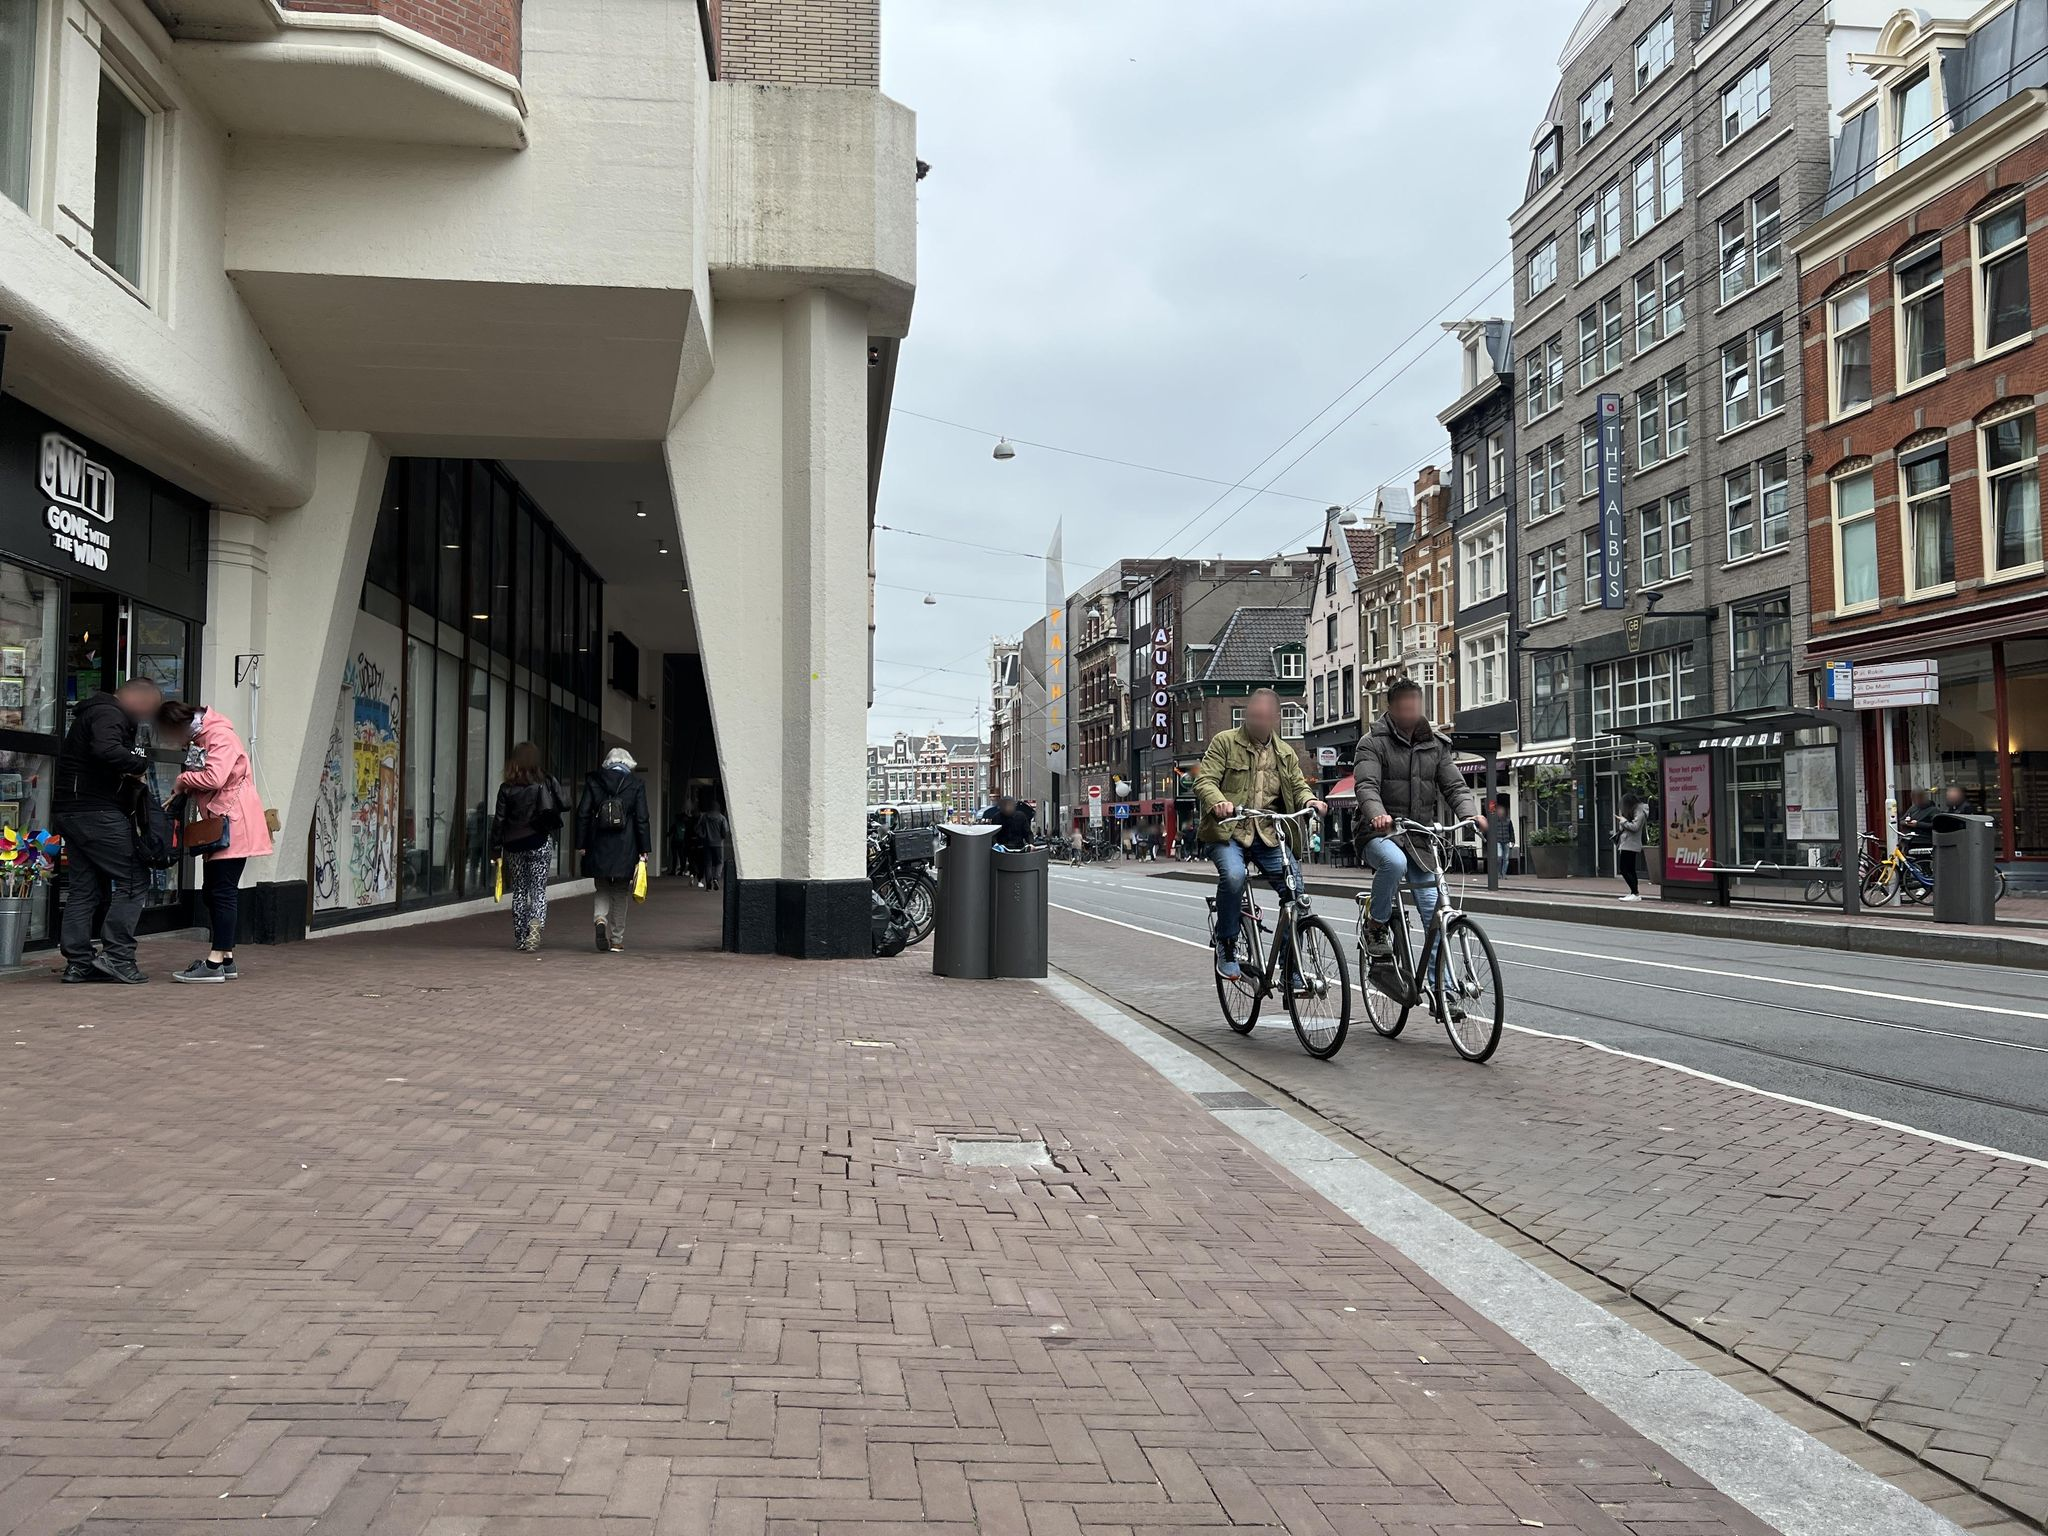

In [40]:
paths = gss.dowload_images(df, mp, kv)
Image.open(paths[0])